In [1]:
!pip install -q transformers datasets
from datasets import load_dataset
from huggingface_hub import notebook_login
notebook_login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.8 MB/s eta 0:00:00


In [ ]:
notebook_login()

In [ ]:
dataset = load_dataset("LucasThil/miniwob_plusplus_v2_raw")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/18124 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/LucasThil___parquet/LucasThil--miniwob_plusplus_v2_raw-5a839e363ad08d45/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
import json

In [ ]:
example = dataset['train'][0]
import re

dom_fields = ['ref', 'parent', 'left', 'top', 'width', 'height', 'tag', 'text', 'value', 'id', 'classes', 'bg_color', 'gf_color', 'flags']

# function to iterate through the DOM elements
def iterate_dom(element):
  focused_element = None
  keydown_text = None

  # Look if the element has the 'focused': True
  if 'focused' in element.keys():
    #print(f'found "focused" for {element["tag"]}, with value {element["focused"]}')
    focused_element = element['ref']
    if 'value' in element.keys():
      keydown_text = element['value']
      #print(f'FOUND KEYDOWN TEXT "{keydown_text}", {element}')
    else:
      keydown_text = ''

  # Now delete all classes we don't need
  # todo

  # Iterate deeper
  new_children = []
  for child in element['children']:
    found_target, found_text, found_dom = iterate_dom(child)
    if found_target is not None:
      focused_element = found_target
    if found_text is not None:
      keydown_text = found_text
    new_children.append(found_dom)

  # Filter the dom
  new_dom = {}
  for field in element.keys():
    if field in dom_fields:
      new_dom[field] = element[field]

  new_dom['children'] = new_children

  return focused_element, keydown_text, new_dom


# Find target actions for each state
def preprocess_episodes(row):
  try:
    states = row['processed_states'].replace("'", '"')
  except:
    #print('error processing state')
    return None
  states = re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), states)
  try:
    states_json = json.loads(states)
  except:
    print(f'error parsin json states: {states}')
    return None

  new_states = []

  for state in states_json:
    #print(f'action_type: {state["action_type"]}')
    #print(state['dom'])


    target_ref, keydown_text, new_dom = iterate_dom(state['dom'])
    #if 'key' in state['action_type']:
      #print(f'FOUND KEYDOWN ACTION: {state}')
      #print(f'action: {state["action_type"]}, target_ref: {target_ref}, keydown_text: {keydown_text}, new_dom: {new_dom}')

    state['refs'] = target_ref

    # modify action_type properly
    if 'key' in state['action_type']:
      state['action_type'] = 'keypress'
    else:
      state['action_type'] = 'click'

    if keydown_text is None:
      state['keydown_text'] = ''
    else:
      state['keydown_text'] = keydown_text

    state['dom'] = new_dom
    new_states.append(state)

  row['processed_states'] = new_states
  return row

i = 0
failed_rows = 0
cleaned_rows = []
for example in dataset['train']:
  if i % 100 == 0:
    print(f'{i} - failed_rows: {failed_rows}')
  #try:
  row = preprocess_episodes(example)
  if row is not None:
    cleaned_rows.append(row)
  else:
    failed_rows += 1
  #except:
   # failed_rows += 1
  i += 1
  if i >= 5000 and False:
    break

print(f'found {failed_rows} failed_rows, and total {len(cleaned_rows)} cleaned_rows')

Output hidden; open in https://colab.research.google.com to view.

Now iterate through the rows, remove actions on body, then randomize refs

In [ ]:
cleaned_rows[0]

{'task_name': 'social-media',
 'utterance': 'For the user @ac, click on the "Like" button.',
 'reward': 0.5782666666666667,
 'raw_reward': 1.0,
 'processed_states': [{'time': 6174,
   'action_type': 'click',
   'dom': {'tag': 'BODY',
    'left': 0,
    'top': 0,
    'width': 1467.2000732421875,
    'height': 210,
    'id': '',
    'classes': '',
    'ref': 1,
    'children': [{'tag': 'DIV',
      'left': 0,
      'top': 0,
      'width': 160,
      'height': 210,
      'id': 'wrap',
      'classes': '',
      'ref': 2,
      'children': [{'tag': 'DIV',
        'left': 0,
        'top': 50,
        'width': 160,
        'height': 154,
        'id': 'area',
        'classes': '',
        'ref': 3,
        'children': [{'tag': 'DIV',
          'left': 4,
          'top': -108,
          'width': 142,
          'height': 62,
          'id': '',
          'classes': 'media',
          'ref': 4,
          'children': [{'tag': 'DIV',
            'left': 9,
            'top': -105,
           

In [ ]:
# First remove duplicated rows
def remove_dumb_actions(row):
  states = row['processed_states']

  valid_states = []
  for state in states:
    target_ref = state['refs']

    # Now find the element with the corresponding div
    try:
      tag = find_tag_ref(state['dom'], target_ref).lower()
    except:
      return None
    if 'body' in tag:
      continue
    else:
      #print(f'found tag: {tag}')
      valid_states.append(state)

  if len(valid_states) > 0:
    row['processed_states'] = valid_states
    #print(f'found {len(valid_states)} valid states')
    return row
  else:
    #print('found no states')
    return None

# find the tag of a specific element based on ref
def find_tag_ref(element, ref):
  #if 'ref' in element.keys():
  if str(element['ref']) == str(ref):
    # Found our element
    return element['tag']
  else:
    for child in element['children']:
      rec_tag = find_tag_ref(child, ref)
      if rec_tag is not None:
        return rec_tag
      else:
        continue
    # nothing found
    return None

new_cleaned = []
i = 0
for row in cleaned_rows:
  if i % 100 == 0:
    print(i)
  if i>5000 and False:
    break
  new_row = remove_dumb_actions(row)
  if new_row is not None:
    new_cleaned.append(new_row)
  i += 1
len(new_cleaned)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300


13412

In [ ]:
import re
import random



# General notes:
#   In total, we'll perform two loops: one for creating initial snippets, the other to randomize the ref numbers, so we are flexible in re-using the code for processing the dataset further

# For each row, html_snippet:
# 1 Get all refs from the (action, ref) tuples
# 2 Get all refs from the html_snippet (we'll update them with the .replace so we are correct with the values)
# 3 Create a random number generator in the range of html_refs without replacement
# 4 Map refs from the (action, ref) tuples to their new number
# 5 Remove all rows where the target ref is the body element
# 6 Replace these refs to the html_snippet
# 7 Create Episodes with Action History

def randomize_refs(html_snippets, refs):

  # 2 - We'll get the refs from all the html episodes. We then concatenate them and get the unique values.
  ref_pattern = r'ref="(\d+)"'

  k = 0
  # Store all ref found in the episodes
  raw_refs = []
  while k < len(html_snippets):
    ref_numbers_episode = [int(m.group(1)) for m in re.finditer(ref_pattern, html_snippets[k])]
    raw_refs += ref_numbers_episode
    k += 1

  # Now get the unique references found
  raw_refs = list(set(raw_refs))
  # print the list of integers

  # 3 - Create the random number generator in that range without replacement
  # generate a list of all numbers in the range
  all_numbers = list(range(1, len(raw_refs)+1))

  # select a random sample of unique numbers from the list
  # Create the random refs
  random_refs = random.sample(all_numbers, len(raw_refs))

  # 4 - Create the dictionary to perform the mapping between the two
  raw2rand = dict(zip(raw_refs, random_refs))
  #rand2raw = dict(zip(random_refs, raw_refs))

  # 5 - Get the ref of the body element
  body_ref = int(html_snippets[len(html_snippets)-1].split('<body ref="')[1].split('"')[0])

  # 6 - Loop to update all ref numbers in the html snippets, and discard the episodes where the target action is targeting the body element
  #     If we find an action targeting the body element, ensure that it is not present in the action_history
  k = 0

  # New lists to contain the updated values
  new_html_snippets = []
  new_actions = []
  new_refs = []
  new_keydown_texts = []

  while k < len(html_snippets):
    if int(refs[k]) == body_ref:
      # Found an action that targets the body ref, discard it and continue
      k += 1
      continue
    else:
      # Update all numbers in the html_snippet + put lowercase
      updating_html = html_snippets[k]
      for new_ref in raw2rand:
        # We add the 'Ø' symbol to mark references already replaced
        updating_html = updating_html.replace('ref="' + str(new_ref) + '"', 'ref="' + str(raw2rand[new_ref]) + 'Ø"')
      # Append the transformerd html snippet to the new_list, and remove the 'Ø' marking the updated values
      new_html_snippets.append(updating_html.replace('Ø', ''))
      # Do the same for the corresponding values
      new_refs.append(raw2rand[int(refs[k])])
      k += 1

  # Now create the correct snippet episodes by iterating and appending the action_history with its correct html snippets
  i = 0
  new_history_episodes = []
  history_actions = ""
  while i < len(new_html_snippets):
    if i == 0:
      history_actions = "{" + new_actions[i] + "," + str(new_refs[i]) + "," + new_keydown_texts[i] + "}"
    else:
      history_actions += "{" + new_actions[i] + "," + str(new_refs[i]) + "," + new_keydown_texts[i] + "}"
    i += 1

  return new_history_episodes, new_html_snippets, new_refs



In [ ]:
# Provide all states, we need to get the references of all episodes
import random
def randomize_refs2(row):
  found_refs = []

  # /!\ check if is json or not
  if len(row['processed_states']) > 100:# and False:
    states = re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), row['processed_states'].replace("'", '"'))
    row['processed_states'] = json.loads(states)

  for state in row['processed_states']:
    found_refs += list(set(get_unique_refs(state['dom'])))
    #print(found_refs)

  # 3 - Create the random number generator in that range without replacement
  # generate a list of all numbers in the range
  all_numbers = list(range(1, len(found_refs)+1))

  # select a random sample of unique numbers from the list
  # Create the random refs
  random_refs = random.sample(all_numbers, len(found_refs))
  #print(random_refs)

  # 4 - Create the dictionary to perform the mapping between the two
  raw2rand = dict(zip(found_refs, random_refs))
  #print(raw2rand, len(raw2rand))

  # Update all states and target refs
  new_states = []
  for state in row['processed_states']:
    state['dom'] = attribute_refs(state['dom'], raw2rand)
    state['refs'] = raw2rand[state['refs']]
    new_states.append(state)

  row['processed_states'] = new_states

  return row

# Replace all refs recursively in the DOM tree
def attribute_refs(dom, raw2rand):
  dom['ref'] = raw2rand[dom['ref']]
  new_children = []
  for child in dom['children']:
    new_children.append(attribute_refs(child, raw2rand))
  dom['children'] = new_children
  return dom

def get_unique_refs(dom):
    found_refs = []
    if 'ref' in dom.keys():
      found_refs.append(int(dom['ref']))
    for child in dom['children']:
      found_refs += get_unique_refs(child)

    return found_refs
#new_cleaned[0]['processed_states'][2]['refs']


In [ ]:
randomized_raw_miniwob_episodes = []
i = 0
for row in new_cleaned:
  if i % 100 == 0:
    print(i)
  randomized_raw_miniwob_episodes.append(randomize_refs2(row))
  i += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400


# Note:
The references are randomized, and body action elements have been removed. But it is important to probably rebalance the dataset with other action types. We can though vizualize the balance between the tasks and judge that way.

In [ ]:
import pandas as pd
df = pd.DataFrame(randomized_raw_miniwob_episodes)
df.to_csv('/content/data.csv', index=False)

In [ ]:
from datasets import load_dataset
file_dict = {
  "train" : "/content/data.csv",
}
df_train = load_dataset("csv", data_files=file_dict)

Extracting data files:   0%|          | 0/1 [00:08<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c0fe11b76f1aab3b/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_train

DatasetDict({
    train: Dataset({
        features: ['task_name', 'utterance', 'reward', 'raw_reward', 'processed_states'],
        num_rows: 13412
    })
})

In [ ]:
df_train.push_to_hub('LucasThil/randomized_raw_miniwob_episodes')

Pushing dataset shards to the dataset hub:   0%|          | 0/6 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/3 [00:00<?, ?it/s]

# Not randomized, fixing it

In [ ]:
dataset = load_dataset("LucasThil/randomized_raw_miniwob_episodes")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/13412 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/LucasThil___parquet/LucasThil--randomized_raw_miniwob_episodes-81f34ee04af6af13/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['task_name', 'utterance', 'reward', 'raw_reward', 'processed_states'],
        num_rows: 13412
    })
})

In [ ]:
dataset['train'][0]

{'task_name': 'email-inbox-nl-turk',
 'utterance': 'Forward the last email from Christine to Nadeen.',
 'reward': 0.6179,
 'raw_reward': 1.0,
 'processed_states': "[{'time': 7242, 'action_type': 'click', 'dom': {'tag': 'BODY', 'left': 0, 'top': 0, 'width': 1299, 'height': 210, 'id': '', 'classes': '', 'ref': 302, 'children': [{'tag': 'DIV', 'left': 0, 'top': 0, 'width': 160, 'height': 210, 'id': 'wrap', 'classes': '', 'ref': 41, 'children': [{'tag': 'DIV', 'left': 0, 'top': 50, 'width': 160, 'height': 164, 'id': 'area', 'classes': '', 'ref': 237, 'children': [{'tag': 'DIV', 'left': 2, 'top': 52, 'width': 156, 'height': 160, 'id': 'forward', 'classes': '', 'ref': 459, 'children': [{'tag': 'DIV', 'left': 2, 'top': 52, 'width': 156, 'height': 21, 'id': 'forward-bar', 'classes': '', 'ref': 378, 'children': [{'tag': 'SPAN', 'left': 5, 'top': 56, 'width': 12, 'height': 12, 'id': 'close-forward', 'classes': '', 'ref': 188, 'text': '', 'children': []}, {'tag': 'SPAN', 'left': 141, 'top': 55, '

In [ ]:
import re
import json
example = dataset['train'][5000]

i = 0
new_rows = []
for row in dataset['train']:
  if i % 100 == 0:
    print(i)
  new_rows.append(randomize_refs2(row))
  i += 1


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400


In [ ]:
import pandas as pd
df = pd.DataFrame(new_rows)
df.to_csv('/content/data.csv', index=False)
df.head()

,task_name,utterance,reward,raw_reward,processed_states
0,email-inbox-nl-turk,Forward the last email from Christine to Nadeen.,0.617900,1.0,"[{'time': 7242, 'action_type': 'click', 'dom':..."
1,email-inbox-nl-turk,"Reply to Melisande with a text, ""Id."".",-1.000000,-1.0,"[{'time': 12181, 'action_type': 'click', 'dom'..."
2,email-inbox-nl-turk,"Send, ""Eget quis tincidunt. Nisl."", to Brit.",0.380867,1.0,"[{'time': 17246, 'action_type': 'click', 'dom'..."
3,email-inbox-nl-turk,I need to respond to Kacey's last email sent t...,-1.000000,-1.0,"[{'time': 13511, 'action_type': 'click', 'dom'..."
4,email-inbox-nl-turk,Find Cynthia's e-mail and reply with the words...,0.500667,1.0,"[{'time': 12843, 'action_type': 'keypress', 'd..."


In [ ]:
from datasets import load_dataset
file_dict = {
  "train" : "/content/data.csv",
}
df_train = load_dataset("csv", data_files=file_dict)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-24fc08f096cb1acc/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_train.push_to_hub('LucasThil/randomized_raw_miniwob_episodes')

Pushing dataset shards to the dataset hub:   0%|          | 0/6 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/6 [00:00<?, ?it/s]

# Need to check the quality of the DOM we got

In [ ]:
dataset = load_dataset("LucasThil/randomized_raw_miniwob_episodes")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/13412 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/LucasThil___parquet/LucasThil--randomized_raw_miniwob_episodes-630c32ce30027f4a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['task_name', 'utterance', 'reward', 'raw_reward', 'processed_states'],
        num_rows: 13412
    })
})

In [ ]:
import re
import json

example = dataset['train'][10]
states = re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), example['processed_states'].replace("'", '"'))
states = json.loads(states)
states[0]['dom'] == states[1]['dom']

False

In [ ]:
i = 0
dom1 = str(states[0]['dom'])
dom2 = str(states[1]['dom'])
while i < len(dom1) and i < len(dom2):
  if dom1[i] != dom2[i]:
    print(f'different at {i}')
    break
  i += 1

different at 1824


In [ ]:
dom1[1814:1830], dom2[1814:1830]

("1, 'ref': 188, '", "1, 'ref': 404, '")

In [ ]:
states[0]['dom']

{'tag': 'BODY',
 'left': 0,
 'top': 0,
 'width': 1215,
 'height': 210,
 'id': '',
 'classes': '',
 'ref': 185,
 'children': [{'tag': 'DIV',
   'left': 0,
   'top': 0,
   'width': 160,
   'height': 210,
   'id': 'wrap',
   'classes': '',
   'ref': 291,
   'children': [{'tag': 'DIV',
     'left': 0,
     'top': 50,
     'width': 160,
     'height': 168,
     'id': 'area',
     'classes': '',
     'ref': 169,
     'children': [{'tag': 'DIV',
       'left': 2,
       'top': 52,
       'width': 156,
       'height': 164,
       'id': 'forward',
       'classes': '',
       'ref': 332,
       'children': [{'tag': 'DIV',
         'left': 2,
         'top': 52,
         'width': 156,
         'height': 21,
         'id': 'forward-bar',
         'classes': '',
         'ref': 123,
         'children': [{'tag': 'SPAN',
           'left': 5,
           'top': 57,
           'width': 12,
           'height': 12,
           'id': 'close-forward',
           'classes': '',
           'ref': 363,
   

# Need to reformat keydown texts into single actions instead of full typing

In [ ]:
dataset = load_dataset("LucasThil/randomized_raw_miniwob_episodes")
dataset

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['task_name', 'utterance', 'reward', 'raw_reward', 'processed_states'],
        num_rows: 13412
    })
})

In [ ]:
example = dataset['train'][10]
example

{'task_name': 'email-inbox-nl-turk',
 'utterance': 'The email that is found in the email app and written by Cyndy needs to be forwarded to Kaila.',
 'reward': 0.3597333333333333,
 'raw_reward': 1.0,
 'processed_states': "[{'time': 11526, 'action_type': 'click', 'dom': {'tag': 'BODY', 'left': 0, 'top': 0, 'width': 1215, 'height': 210, 'id': '', 'classes': '', 'ref': 185, 'children': [{'tag': 'DIV', 'left': 0, 'top': 0, 'width': 160, 'height': 210, 'id': 'wrap', 'classes': '', 'ref': 291, 'children': [{'tag': 'DIV', 'left': 0, 'top': 50, 'width': 160, 'height': 168, 'id': 'area', 'classes': '', 'ref': 169, 'children': [{'tag': 'DIV', 'left': 2, 'top': 52, 'width': 156, 'height': 164, 'id': 'forward', 'classes': '', 'ref': 332, 'children': [{'tag': 'DIV', 'left': 2, 'top': 52, 'width': 156, 'height': 21, 'id': 'forward-bar', 'classes': '', 'ref': 123, 'children': [{'tag': 'SPAN', 'left': 5, 'top': 57, 'width': 12, 'height': 12, 'id': 'close-forward', 'classes': '', 'ref': 363, 'text': '',

In [ ]:
import json
import re

# Find a ref element and removes its text input content
# Done to not have the text inside before performing keypress action
def remove_text_ref_value(dom, ref):
  if str(dom['ref']) == str(ref):
    dom['value'] = ''
    return dom, True
  elif 'children' in dom.keys():
    for index, child in enumerate(dom['children']):
      new_child, flag = remove_text_ref_value(child, ref)
      if flag:
        dom['children'][index] = new_child
        return dom, True
      else:
        continue
    return dom, False


# Removes intermediate keydown actions
# Gets correct target text for keydown actions
# This function assumes that all episodes end by a click action
def reformat_keydown_texts(row):
  states = re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), row['processed_states'].replace("'", '"'))
  states = json.loads(states)

  # Basically only keep click state-actions + last keydown state_actions by removing all intermediate typing
  valid_states = []

  current_keydown = False
  # Keeps track of the previous keydown state, if new state is click, appends this one
  previous_keydown_state = None

  # If we find repeating states, we discard them
  previous_state = None

  for state in states:
    if state['action_type'] == 'click':
      if current_keydown:
        # add last keydown state
        # delete its target input from text
        previous_keydown_state['dom'], _ = remove_text_ref_value(previous_keydown_state['dom'], previous_keydown_state['refs'])
        # correct target keydown action by taking the next click state
        previous_keydown_state['keydown_text'] = state['keydown_text']
        valid_states.append(previous_keydown_state)
        # resets
        previous_keydown_state = None
        current_keydown = False

      if state != previous_state:
        # Removed target text for click actions
        state['keydown_text'] = ''
        valid_states.append(state)
      # keep track of previous state
      previous_state = state

    elif state['action_type'] == 'keypress':
      current_keydown = True
      previous_keydown_state = state
    else:
      print(f'ERROR ACTION TYPE: {state}')

  row['processed_states'] = valid_states
  return row

In [ ]:
new_dataset = []

i = 0
for row in dataset['train']:
  if i % 100 == 0:
    print(i)
  new_dataset.append(reformat_keydown_texts(row))
  i += 1

  if i>50 and False:
    break

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400


In [ ]:
new_dataset[200]

{'task_name': 'email-inbox-nl-turk',
 'utterance': 'respond to Gabriella with "Pellentesque."',
 'reward': 0.4869666666666666,
 'raw_reward': 1.0,
 'processed_states': [{'time': 6299,
   'action_type': 'click',
   'dom': {'tag': 'BODY',
    'left': 0,
    'top': 0,
    'width': 1154,
    'height': 210,
    'id': '',
    'classes': '',
    'ref': 376,
    'children': [{'tag': 'DIV',
      'left': 0,
      'top': 0,
      'width': 160,
      'height': 210,
      'id': 'wrap',
      'classes': '',
      'ref': 487,
      'children': [{'tag': 'DIV',
        'left': 0,
        'top': 50,
        'width': 160,
        'height': 158,
        'id': 'area',
        'classes': '',
        'ref': 435,
        'children': [{'tag': 'DIV',
          'left': 2,
          'top': 52,
          'width': 156,
          'height': 154,
          'id': 'reply',
          'classes': '',
          'ref': 891,
          'children': [{'tag': 'DIV',
            'left': 2,
            'top': 52,
            'widt

In [ ]:
import pandas as pd
df = pd.DataFrame(new_dataset)
df.to_csv('/content/data.csv', index=False)
df.head()

,task_name,utterance,reward,raw_reward,processed_states
0,email-inbox-nl-turk,Forward the last email from Christine to Nadeen.,0.617900,1.0,"[{'time': 7242, 'action_type': 'click', 'dom':..."
1,email-inbox-nl-turk,"Reply to Melisande with a text, ""Id."".",-1.000000,-1.0,"[{'time': 12181, 'action_type': 'click', 'dom'..."
2,email-inbox-nl-turk,"Send, ""Eget quis tincidunt. Nisl."", to Brit.",0.380867,1.0,"[{'time': 17246, 'action_type': 'click', 'dom'..."
3,email-inbox-nl-turk,I need to respond to Kacey's last email sent t...,-1.000000,-1.0,"[{'time': 13511, 'action_type': 'click', 'dom'..."
4,email-inbox-nl-turk,Find Cynthia's e-mail and reply with the words...,0.500667,1.0,"[{'time': 12847, 'action_type': 'keypress', 'd..."


In [ ]:
from datasets import load_dataset
file_dict = {
  "train" : "/content/data.csv",
}
df_train = load_dataset("csv", data_files=file_dict)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2ae0eb658a11f0be/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_train.push_to_hub('LucasThil/randomized_raw_miniwob_episodes')

Pushing dataset shards to the dataset hub:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/6 [00:00<?, ?it/s]

# Finally, ensure no duplicate actions are present.
Previously, we checked whether no two states were the same, but after investigation, it seems that it is better to simply remove repeating action and discard found dom changes.

In [ ]:
dataset = load_dataset("LucasThil/randomized_raw_miniwob_episodes")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/13412 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/LucasThil___parquet/LucasThil--randomized_raw_miniwob_episodes-842096a212c79e37/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['task_name', 'utterance', 'reward', 'raw_reward', 'processed_states'],
        num_rows: 13412
    })
})

In [ ]:
import re
import json


def remove_double_actions(row):
  states = re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), row['processed_states'].replace("'", '"'))
  states = json.loads(states)

  new_states = []
  previous_ref = None
  previous_action_type = None
  for state in states:
    current_ref = state['refs']
    current_action_type = state['action_type']

    if previous_ref == current_ref and previous_action_type == current_action_type:
      current_ref = previous_ref
      current_action_type = previous_action_type
    else:
      previous_ref = current_ref
      previous_action_type = current_action_type
      new_states.append(state)

  row['processed_states'] = new_states
  return row

In [ ]:
example = dataset['train'][5]
print(len(json.loads(re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), example['processed_states'].replace("'", '"')))))
result = remove_double_actions(example)
print(len(result['processed_states']))

5
3


In [ ]:
i = 0
new_dataset = []
for row in dataset['train']:
  if i % 100 == 0:
    print(i)
  new_dataset.append(remove_double_actions(row))
  i += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400


In [ ]:
import pandas as pd
df = pd.DataFrame(new_dataset)
df.to_csv('/content/data.csv', index=False)
df.head()

,task_name,utterance,reward,raw_reward,processed_states
0,email-inbox-nl-turk,Forward the last email from Christine to Nadeen.,0.617900,1.0,"[{'time': 7242, 'action_type': 'click', 'dom':..."
1,email-inbox-nl-turk,"Reply to Melisande with a text, ""Id."".",-1.000000,-1.0,"[{'time': 12181, 'action_type': 'click', 'dom'..."
2,email-inbox-nl-turk,"Send, ""Eget quis tincidunt. Nisl."", to Brit.",0.380867,1.0,"[{'time': 17246, 'action_type': 'click', 'dom'..."
3,email-inbox-nl-turk,I need to respond to Kacey's last email sent t...,-1.000000,-1.0,"[{'time': 13511, 'action_type': 'click', 'dom'..."
4,email-inbox-nl-turk,Find Cynthia's e-mail and reply with the words...,0.500667,1.0,"[{'time': 12847, 'action_type': 'keypress', 'd..."


In [ ]:
from datasets import load_dataset
file_dict = {
  "train" : "/content/data.csv",
}
df_train = load_dataset("csv", data_files=file_dict)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-60252a5ea28c5873/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_train.push_to_hub('LucasThil/randomized_clean_miniwob_episodes_v2')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

# Add the images for each episode state

In [ ]:
# Unzip the reconstructed images

!apt-get install unar
!unar /content/screenshot_indexes.zip -o /content/screenshot_indexes


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  gnustep-base-common gnustep-base-runtime gnustep-common libgnustep-base1.26
The following NEW packages will be installed:
  gnustep-base-common gnustep-base-runtime gnustep-common libgnustep-base1.26
  unar
0 upgraded, 5 newly installed, 0 to remove and 24 not upgraded.
Need to get 2,947 kB of archives.
After this operation, 14.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-common amd64 2.7.0-4 [39.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-base-common all 1.26.0-7 [70.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libgnustep-base1.26 amd64 1.26.0-7 [1,331 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-base-runtime amd64 1.26.0-7 [208 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/universe amd64 un

In [ ]:
import zipfile

zip_file_path = '/content/screenshot_indexes.zip'  # Specify the path to your zip file
destination_folder = '/content/'  # Specify the destination folder to extract the contents

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)


BadZipFile: ignored

In [ ]:

from datasets import load_dataset
dataset = load_dataset("LucasThil/randomized_clean_miniwob_episodes_v2")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/13412 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/LucasThil___parquet/LucasThil--randomized_clean_miniwob_episodes_v2-49501296fc0102ba/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:

# Load some of the images we have here and try to save them to the dataset
import os
from io import BytesIO
from PIL import Image
from typing import List, Tuple
import numpy as np

def get_file_indices() -> List[Tuple[int, int]]:
    dir_path = '/content/compressed_screenshots/'
    indices = []
    for filename in os.listdir(dir_path):
        if filename.endswith('.png'):
            # Extract the N and K values from the filename
            N, K = filename.replace('sc_', '').replace('st_', '').replace('.png', '').split('_')
            N = int(N)
            K = int(K)
            indices.append((N, K))
    return indices

import os
import torch

def read_image(N, K) -> torch.Tensor:
    dir_path = '/content/compressed_screenshots/'
    filename = f'sc_{N}_st_{K}.png'
    filepath = os.path.join(dir_path, filename)
    image = Image.open(filepath).convert('RGB')
    # Convert to numpy array, then to list
    data = np.array(image).tolist()
    #tensor = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255.0
    return data


In [ ]:
import numpy as np
import json
# Function to append them to the dataset
def sort_tuples(tuples_list):
    return sorted(tuples_list, key=lambda x: (x[0], x[1]))

# File name indexes of rows + episodes in a sorted manner
filename_indexes = sort_tuples(get_file_indices())

# Allocate vector
img_data = [''] * len(dataset['train'])
print(len(img_data))

# Add picture data into it
current_episode_index = 0
current_episode_pics = []
for index, (N, K) in enumerate(filename_indexes):
    loaded_image = read_image(N, K)#.reshape(-1)
    print(N, K, len(loaded_image))

    if current_episode_index == N:
        current_episode_pics.append(loaded_image)
    else:
        img_data[current_episode_index] = json.dumps(current_episode_pics)
        print(f'    {index} len {len(img_data[current_episode_index])}')
        current_episode_index = N
        current_episode_pics = [loaded_image]
        #current_episode_pics.append(loaded_image)

    # Load first 5000 episodes
    if current_episode_index > 5000 and True:
        break

img_data[0], len(img_data)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
4160 1 210
4160 2 210
4160 3 210
4160 4 210
4161 0 210
    14769 len 2809102
4161 1 210
4161 2 210
4161 3 210
4161 4 210
4162 0 210
    14774 len 2809556
4162 1 210
4162 2 210
4162 3 210
4162 4 210
4163 0 210
    14779 len 2809474
4163 1 210
4163 2 210
4164 0 210
    14782 len 1687023
4164 1 210
4164 2 210
4164 3 210
4165 0 210
    14786 len 2247774
4166 0 210
    14787 len 562307
4166 1 210
4166 2 210
4166 3 210
4167 0 210
    14791 len 2248138
4167 1 210
4167 2 210
4168 0 210
    14794 len 1686867
4168 1 210
4168 2 210
4168 3 210
4168 4 210
4169 0 210
    14799 len 2809618
4169 1 210
4170 0 210
    14801 len 1124490
4170 1 210
4170 2 210
4171 0 210
    14804 len 1685579
4171 1 210
4171 2 210
4171 3 210
4172 0 210
    14808 len 2247642
4172 1 210
4172 2 210
4172 3 210
4173 0 210
    14812 len 2247872
4173 1 210
4173 2 210
4173 3 210
4173 4 210
4174 0 210
    14817 len 2809375
4174 1 210
4174 2 210
4174 3 210

('[[[[255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [255, 255, 84], [25

In [ ]:
# Take the first 5000 entries of the dataset
# select how much of the datset we want to use
dataset['train'] = dataset["train"].select(range(5000))
dataset

DatasetDict({
    train: Dataset({
        features: ['task_name', 'utterance', 'reward', 'raw_reward', 'processed_states'],
        num_rows: 5000
    })
})

In [ ]:
dataset['train'] = dataset['train'].add_column('img', img_data[:5000])

In [ ]:
dataset['train']

Dataset({
    features: ['task_name', 'utterance', 'reward', 'raw_reward', 'processed_states', 'img'],
    num_rows: 5000
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['task_name', 'utterance', 'reward', 'raw_reward', 'processed_states', 'img'],
        num_rows: 5000
    })
})

In [ ]:
dataset.push_to_hub('LucasThil/randomized_clean_miniwob_episodes__image0_5000_v2')

Pushing dataset shards to the dataset hub:   0%|          | 0/22 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import gc
img_data = 0
gc.collect()

0

In [ ]:
import pandas as pd
df = pd.DataFrame(img_data)
df.head()

,0
0,"[[[[255, 255, 84], [255, 255, 84], [255, 255, ..."
1,"[[[[255, 255, 84], [255, 255, 84], [255, 255, ..."
2,"[[[[255, 255, 84], [255, 255, 84], [255, 255, ..."
3,"[[[[255, 255, 84], [255, 255, 84], [255, 255, ..."
4,"[[[[255, 255, 84], [255, 255, 84], [255, 255, ..."


In [ ]:
df.to_csv('/content/images.csv')

In [ ]:
read_image(0, 0)

array([[[255, 255,  84],
        [255, 255,  84],
        [255, 255,  84],
        ...,
        [255, 255,  84],
        [255, 255,  84],
        [255, 255,  84]],

       [[255, 255,  84],
        [255, 255,  84],
        [255, 255,  84],
        ...,
        [255, 255,  84],
        [255, 255,  84],
        [255, 255,  84]],

       [[255, 255,  84],
        [255, 255,  84],
        [255, 255,  84],
        ...,
        [255, 255,  84],
        [255, 255,  84],
        [255, 255,  84]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
import pandas as pd
df = pd.read_csv('/content/images.csv')
df.head()

# Show distribution of tasks

In [3]:
dataset = load_dataset("LucasThil/miniwob_plusplus_v2_raw")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/18124 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/LucasThil___parquet/LucasThil--miniwob_plusplus_v2_raw-5a839e363ad08d45/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['task_name', 'utterance', 'reward', 'raw_reward', 'processed_states'],
        num_rows: 18124
    })
})

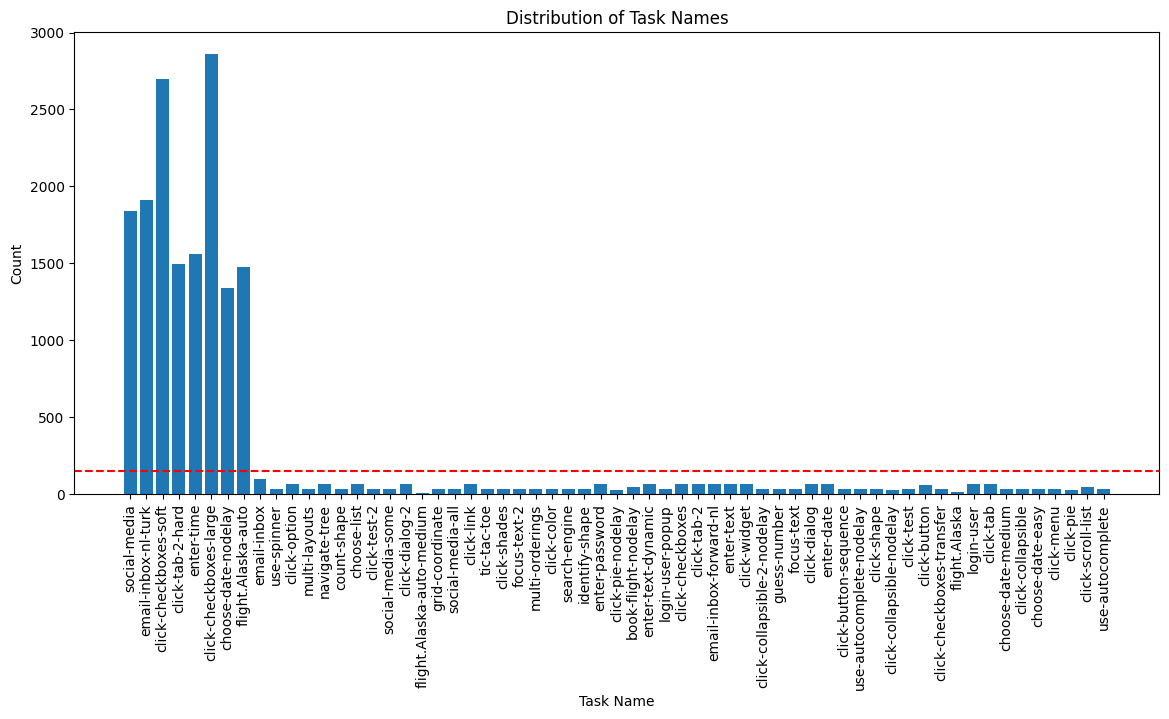

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# Get the task_names
task_names = dataset["train"]["task_name"]

# Filter out None values
task_names = [task_name for task_name in task_names if task_name is not None]

# Count the occurrences of each task_name
task_name_counts = Counter(task_names)

# Plot the distribution
task_names, counts = zip(*task_name_counts.items())
plt.figure(figsize=(14, 6))  # Adjust the width and height as needed
plt.bar(task_names, counts)
plt.axhline(y=150, color='red', linestyle='--', label='Threshold')
plt.xlabel("Task Name")
plt.ylabel("Count")
plt.title("Distribution of Task Names")
plt.xticks(rotation=90)
plt.show()

In [6]:
# Get the total average of all columns
capped_counts = [min(count, 150) for count in task_name_counts.values()]
average_count = sum(capped_counts) / len(task_name_counts)
average_count

56.278688524590166

In [10]:
capped_counts_dict = {}
for i in range(len(capped_counts)):
  capped_counts_dict[task_names[i]] = capped_counts[i]
capped_counts_dict

{'social-media': 150,
 'email-inbox-nl-turk': 150,
 'click-checkboxes-soft': 150,
 'click-tab-2-hard': 150,
 'enter-time': 150,
 'click-checkboxes-large': 150,
 'choose-date-nodelay': 150,
 'flight.Alaska-auto': 150,
 'email-inbox': 98,
 'use-spinner': 32,
 'click-option': 62,
 'multi-layouts': 32,
 'navigate-tree': 62,
 'count-shape': 32,
 'choose-list': 63,
 'click-test-2': 32,
 'social-media-some': 32,
 'click-dialog-2': 62,
 'flight.Alaska-auto-medium': 7,
 'grid-coordinate': 32,
 'social-media-all': 32,
 'click-link': 68,
 'tic-tac-toe': 32,
 'click-shades': 32,
 'focus-text-2': 32,
 'multi-orderings': 32,
 'click-color': 32,
 'search-engine': 32,
 'identify-shape': 32,
 'enter-password': 62,
 'click-pie-nodelay': 28,
 'book-flight-nodelay': 43,
 'enter-text-dynamic': 62,
 'login-user-popup': 32,
 'click-checkboxes': 64,
 'click-tab-2': 62,
 'email-inbox-forward-nl': 64,
 'enter-text': 62,
 'click-widget': 62,
 'click-collapsible-2-nodelay': 32,
 'guess-number': 32,
 'focus-text':

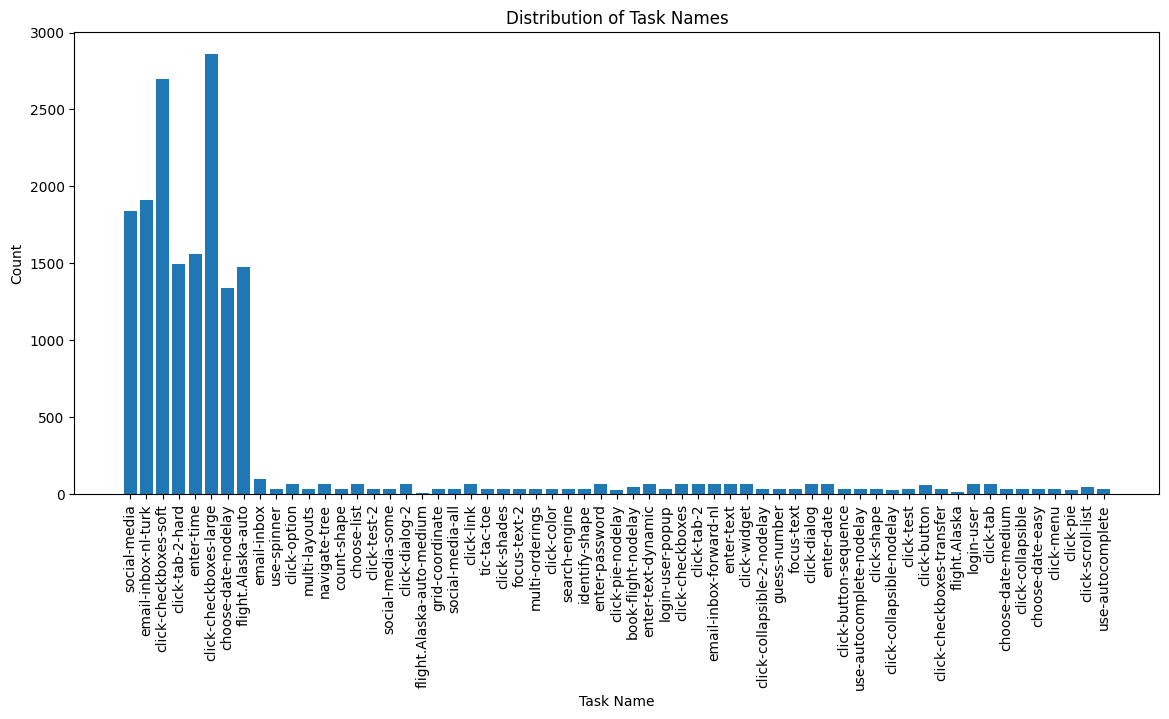

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# Get the task_names
task_names = dataset["train"]["task_name"]

# Filter out None values
task_names = [task_name for task_name in task_names if task_name is not None]

# Count the occurrences of each task_name
task_name_counts = Counter(task_names)

# Plot the distribution
task_names, counts = zip(*task_name_counts.items())
plt.figure(figsize=(14, 6))  # Adjust the width and height as needed
plt.bar(task_names, counts)
plt.xlabel("Task Name")
plt.ylabel("Count")
plt.title("Distribution of Task Names")
plt.xticks(rotation=90)
plt.show()

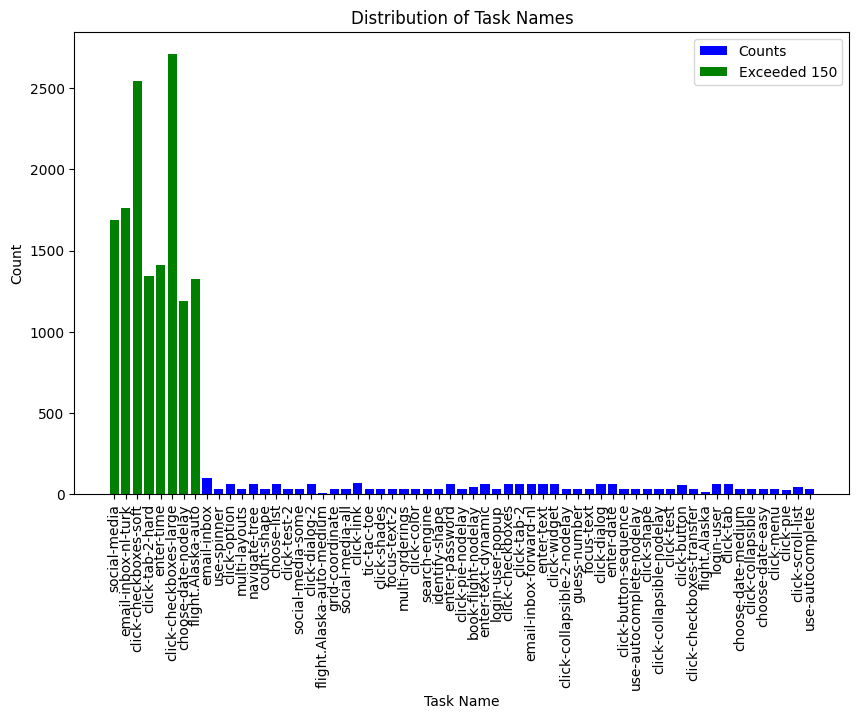

In [ ]:

# Get the task_names
task_names = dataset["train"]["task_name"]

# Filter out None values
task_names = [task_name for task_name in task_names if task_name is not None]

# Count the occurrences of each task_name
task_name_counts = Counter(task_names)

# Prepare data for plotting
task_names, counts = zip(*task_name_counts.items())
# Calculate the counts that exceed 150
counts_above_threshold = [count if count <= 150 else 150 for count in counts]
# Calculate the counts that exceed 150 (for the green bars)
counts_green_bars = [count - 150 if count > 150 else 0 for count in counts]

# Plot the distribution with a wider figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed
plt.bar(task_names, counts_above_threshold, color='blue', label='Counts')
plt.bar(task_names, counts_green_bars, color='green', label='Exceeded 150')
plt.xlabel("Task Name")
plt.ylabel("Count")
plt.title("Distribution of Task Names")
plt.xticks(rotation=90)
plt.legend()
plt.show()
